# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer 1

We would split on the first digit using information gain. The other two features have different features for different classes. Taking either the 2nd or the 3rd feature as the second node, the expected error is 25%.

#### Answer 2

Root X2 == 0 
    
    true:
      X3 == 0
      true:
        retrun 1
      false:
        return 0
    
    false:
      X3 == 0
      true:
        retrun 0
      false:
        return 1

## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the bostom dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



In [123]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

In [156]:
class TreeEnsemble():

    def __init__(self, n_trees, sample_sz, min_leaf):
#         self.X = X
#         self.y = y
        self.trees = []
        self.n_trees = n_trees
        self.sample_sz = sample_sz
        self.min_leaf = min_leaf
        self.fit(X, y)
#         return self
        
        
    def fit(self, X, y):
        for tree_i in range(self.n_trees):
            tree = DecisionTree(self.sample_sz, self.min_leaf)
            self.trees.append(tree.fit(X, y))
        return self
  
    def predict(self, X):
        pred = []
        for tree in self.trees:
            pred.append(tree.predict(X))
        return np.asarray(pred).mean(axis=0)

    def oob_mse(self):
        errors = []
        for tree in self.trees:
            errors.append(tree.oob_mse())
        return np.asarray(errors).mean()

In [152]:
class DecisionTree():
    
    def __init__(self, sample_sz, min_leaf):
        self.min_leaf = min_leaf
        self.sample_size =  sample_sz

        
    def fit(self, X, y):
        # sample from X
        num_samples = X.shape[0]
        sample = np.random.randint(0, num_samples, self.sample_size) #I don't think it's the correct function: can have twice the same result
        self.X = X[sample]
        self.y = y[sample]
        not_sampled = [i for i in np.arange(num_samples) if i not in sample] # better way to do it ?
        self.oob_X = X[not_sampled]
        self.oob_y = y[not_sampled]
        # call recursive builder
        self.top_node = Node()
        self.recursive_tree_builder(self.X, self.y, self.top_node)
        return self

    def predict(self, X):
        # run on all trees and get proba per classes (make into vector and then avergae columns)
        return np.apply_along_axis(self.predict_single, arr=X, axis=1)
    
    def predict_single(self, x):
        node = self.top_node
        val = node.value
        feat_idx = node.feature
        while(True):
            if node.value is None or node.feature is None:
                return node.mean
            if x[feat_idx] > val:
                node = node.bigger
                val = node.value
                feat_idx = node.feature
            else:
                node = node.smaller
                val = node.value
                feat_idx = node.feature
                
    def oob_mse(self):
         return mean_squared_error(self.predict(self.oob_X), self.oob_y)
    
    
    def recursive_tree_builder(self, X, y, curr_node):
#         print(f'Recursifying size of X: {X.shape[0]}')
        #if we have less than min leaf we return
        if X.shape[0] <= 2 * self.min_leaf:
            # update as end node with proba
            curr_node.mean = np.mean(y)
#             print(f'Pred1: {curr_node.class_probas}')
            return
        else:
            # find best feature to split by
            curr_node.feature, curr_node.value = self.best_split(X, y)
            if curr_node.value is None:
                curr_node.mean = np.mean(y)
#                 print(f'Pred2: {curr_node.class_probas}')
                return
            bigger = X[:,curr_node.feature] > curr_node.value
            smaller = X[:,curr_node.feature] <= curr_node.value
            self.recursive_tree_builder(X[bigger,:], y[bigger], curr_node.set_bigger())
            self.recursive_tree_builder(X[smaller,:], y[smaller], curr_node.set_smaller())
            return
            
            
    def best_split(self, X, y):
        # for each feature we check 'all' points and take point with lowest
        kwargs = {'y': y, 'min_leaf':self.min_leaf}
        min_split_per_feature, error = np.apply_along_axis(self.get_min_split, arr=X, axis=0, **kwargs)
        feature = np.argmin(error)
        split_val = min_split_per_feature[feature]
#         print(f'Feature found: {feature} Error: {np.min(error)}, Split val: {split_val}')
        return feature, split_val
                                   
    def get_min_split(self, feat, y, min_leaf):
        idxs = np.argsort(feat)
        feat = np.sort(feat)
        y = y[idxs]
        bounds = feat[min_leaf: -(min_leaf + 1)]

        min_error = math.inf
        split_val = None
        for trial in bounds:
            if self.bad_trial(trial, feat):
                pass
            error = self.get_var_error(trial, feat, y)
            if error < min_error:
                min_error = error
                split_val = trial
#         print(f'Split found: {split_val} Error: {min_error}')
        return (split_val, min_error)

    def bad_trial(self, split, feat):
        bigger = feat > split
        smaller = feat <= split
        return (feat[bigger].shape[0] <= self.min_leaf) or (feat[smaller].shape[0] <= self.min_leaf)
                                
    def get_var_error(self, split, feat, y):
        bigger = feat > split
        smaller = feat <= split

        var_bigger = np.square(np.var(feat[bigger]))
        var_smaller = np.square(np.var(feat[smaller]))
        
        bigger_size = feat[bigger].shape[0]
        smaller_size = feat[smaller].shape[0]
        n = feat.shape[0]

        return (bigger_size/n)*var_bigger + (smaller_size/n)*var_smaller

In [154]:
class Node:
    
    
    def __init__(self):
        self.feature = None
        self.value = None
        self.smaller = None
        self.bigger = None
        self.mean = None

    def set_bigger(self):
        """
        Creates child, adds to child list and returns child
        """
        self.bigger = Node()
        return self.bigger
                                   
    def set_smaller(self):
        """
        Creates child, adds to child list and returns child
        """
        self.smaller = Node()
        return self.smaller

    def is_leaf(self):
        return self.smaller is None and self.bigger is None
    
    def print_tree(self, depth):
        if self.is_leaf():
             print(f'Probas: {self.mean}')
        else:
            print(f'Node level {depth}, Feature: {self.feature}, Split val: {self.value}')
            self.smaller.print_tree(depth+1)
            self.bigger.print_tree(depth+1)

In [144]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd

In [145]:

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [125]:
import warnings
warnings.filterwarnings('ignore')

In [126]:
for n in [1,5,10,20,50,100]:
# for n in [5,10,20,50,100]:
    for sz in [50,100,300,500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(X, y, n, sz, min_leaf)
#             forest.fit(X, y)
#             forest = TreeEnsemble(data1.loc[:,0:12], data1.loc[:,12:13], n, sz, min_leaf)
            mse = forest.oob_mse()
            print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))

n_trees:1, sz:50, min_leaf:1 --- oob mse: 92.22992556281773
n_trees:1, sz:50, min_leaf:5 --- oob mse: 83.94040637358003
n_trees:1, sz:100, min_leaf:1 --- oob mse: 66.29988133121188
n_trees:1, sz:100, min_leaf:5 --- oob mse: 62.71363580129761
n_trees:1, sz:300, min_leaf:1 --- oob mse: 45.25025299463031
n_trees:1, sz:300, min_leaf:5 --- oob mse: 61.08730297613808
n_trees:1, sz:500, min_leaf:1 --- oob mse: 45.13956552706553
n_trees:1, sz:500, min_leaf:5 --- oob mse: 60.600028290148536
n_trees:5, sz:50, min_leaf:1 --- oob mse: 87.79685532579335
n_trees:5, sz:50, min_leaf:5 --- oob mse: 78.28635558784312
n_trees:5, sz:100, min_leaf:1 --- oob mse: 73.99497591206018
n_trees:5, sz:100, min_leaf:5 --- oob mse: 63.02052618153009
n_trees:5, sz:300, min_leaf:1 --- oob mse: 56.625978058208695
n_trees:5, sz:300, min_leaf:5 --- oob mse: 50.89055491068475
n_trees:5, sz:500, min_leaf:1 --- oob mse: 41.672099870831275
n_trees:5, sz:500, min_leaf:5 --- oob mse: 46.60971109390486
n_trees:10, sz:50, min_le

In [157]:

print("getting y from my model")
y_my_model = TreeEnsemble(n_trees=5, sample_sz=500, min_leaf=1).fit(X_train, y_train).predict(X_test)


getting y from my model
getting y from my model


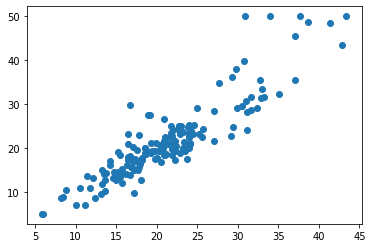

In [159]:
import matplotlib.pyplot as plt

plt.scatter(y_my_model, y_test)

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

In [5]:
# code and answer go here
import keras
import numpy as np
from keras.datasets import mnist
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

In [2]:
param_grid_RF = {
    'n_estimators' : [10,50,100],
    'criterion': ['gini','entropy'],
    'max_depth' : [None,50,100],
    'max_features' : [None,"sqrt","log2"],
    'bootstrap' : [True],
    'oob_score' : [True]
}


clf_RF = RandomForestClassifier(random_state=0)
search_RF = GridSearchCV(clf_RF, param_grid_RF, cv=5, verbose=10, n_jobs=-1).fit(X_train, y_train)
best_CLF_RF = clf_RF.set_params(**search_RF.best_params_)
best_CLF_RF.fit(X_train,y_train)
best_CLF_RF_test_score = best_CLF_RF.score(X_test,y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 44.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 131.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 135.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 137.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 255.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 265.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 267.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 290.5min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 302.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | ela

It took a crazy amount of time to generate 

In [7]:
print("===============")
print("RF grid results")
print("===============")
print(f'Best parameters : {search_RF.best_params_}')
print(f'CV accuracy : {np.round(100*search_RF.best_score_,1)}%')
print(f'test accuracy : {np.round(100*best_CLF_RF_test_score,1)}%')

RF grid results
Best parameters : {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': True}
CV accuracy : 96.7%
test accuracy : 97.0%


In [6]:
from sklearn.model_selection import RandomizedSearchCV

random_grid_DT = {
    'criterion': ['gini','entropy'],
    'max_depth' : [None,10,100],
    'max_features' : [None,"sqrt","log2"],
    'min_samples_split': [2,5,7]
}

clf_DT = DecisionTreeClassifier(random_state=0)
search_DT = RandomizedSearchCV(clf_DT, random_grid_DT, cv=5, verbose=10,n_jobs=-1).fit(X_train, y_train)

best_CLF_DT = clf_DT.set_params(**search_DT.best_params_)
best_CLF_DT.fit(X_train,y_train)
best_CLF_DT_test_score = best_CLF_DT.score(X_test,y_test)

print("=======+++++++========")
print("DT RANDOM GRID results")
print("=======+++++++========")
print(f'Best parameters : {search_DT.best_params_}')
print(f'CV accuracy : {np.round(100*search_DT.best_score_,1)}%')
print(f'test accuracy : {np.round(100*best_CLF_DT_test_score,1)}%')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   42.8s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   58.6s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.0min finished


=======+++++++========
DT RANDOM GRID results
=======+++++++========
Best parameters : {'min_samples_split': 5, 'max_features': None, 'max_depth': None, 'criterion': 'entropy'}
CV accuracy : 87.2%
test accuracy : 88.6%


Feature importance


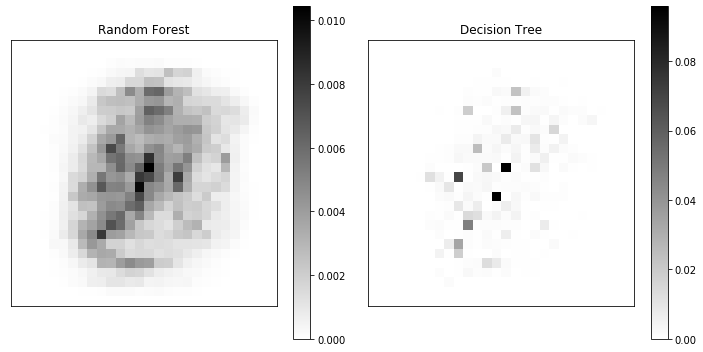

In [9]:
import matplotlib.pyplot as plt

print("==================")
print("Feature importance")
print("==================")

plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)
ax.set_title('Random Forest')
im = ax.imshow(best_CLF_RF.feature_importances_.reshape((28,28)),cmap=plt.cm.gray_r);
ax.set_xticks([])
ax.set_yticks([]);
plt.colorbar(im);

ax = plt.subplot(1,2,2)
ax.set_title('Decision Tree')
im = ax.imshow(best_CLF_DT.feature_importances_.reshape((28,28)),cmap=plt.cm.gray_r);
ax.set_xticks([])
ax.set_yticks([]);
plt.colorbar(im);

plt.tight_layout()
plt.show()

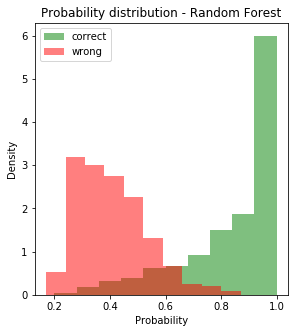

In [10]:
y_hat = best_CLF_RF.predict(X_test)
right_idxs = y_hat == y_test
wrong_idxs = ~right_idxs
probs = np.max(best_CLF_RF.predict_proba(X_test),axis=1)


plt.figure(figsize=(10,5))

ax = plt.subplot(1,2,1)

ax.hist(probs[right_idxs],label='correct',density=True,color='g',alpha=0.5)
ax.hist(probs[wrong_idxs],label='wrong',density=True,color='r',alpha=0.5)
ax.legend()
ax.set_title('Probability distribution - Random Forest')
ax.set_xlabel('Probability')
ax.set_ylabel('Density');

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/